<a href="https://colab.research.google.com/github/KateFilippova/Birds/blob/main/GDD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import plotly.express as px
import requests
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.optimize import curve_fit
import math
from scipy.misc import derivative
from scipy.signal import find_peaks

In [ ]:
# читаем данные по точке
df = pd.read_csv('hrc_GWFG_2018_477_temp.csv')
df.head()

,Unnamed: 0,datetime,temp
0,0,2021-03-01,2.4
1,1,2021-03-02,2.7
2,2,2021-03-03,1.8
3,3,2021-03-04,-1.0
4,4,2021-03-05,-3.9


# Считаем GDD

GDD - показатель накопления тепла.

Рассчитывала по формуле:

GDD-formula.svg

Причем, если минимальная температура T min ниже базовой T, то b1.svg заменяем на b2.svg

**Tbase** считаем по формуле: TBASE = –0.25 * latitude + 13

In [ ]:
# расчет Tbase
def t_base(latitude):
    return round((-0.25*latitude + 13), 1)

t_base = t_base(58.9026113)
print('Базовая температура =', t_base)

Базовая температура = -1.7


In [ ]:
# расчет GDD
def gdd_formula(temp_mean, t_base):
    '''
    :param a: список среднедневных температур 
    :param b: Tbase
    :return: список GDD 
    '''
    gdd = []
    for t in temp_mean:
        if t >= t_base:
            gdd.append(round((t - t_base), 1))
        else:
            gdd.append(0)
    
    return gdd

Добавляем в таблицу столбец с GDD

In [ ]:
df['GDD'] = pd.DataFrame(gdd_formula(df['temp'].tolist(), t_base)).cumsum()
df

,Unnamed: 0,datetime,temp,GDD
0,0,2021-03-01,2.4,4.1
1,1,2021-03-02,2.7,8.5
2,2,2021-03-03,1.8,12.0
3,3,2021-03-04,-1.0,12.7
4,4,2021-03-05,-3.9,12.7
...,...,...,...,...
87,87,2021-05-27,10.8,593.5
88,88,2021-05-28,11.0,606.2
89,89,2021-05-29,10.0,617.9
90,90,2021-05-30,9.7,629.3


# Строим график GDD и вычисляем параметры сигмоида

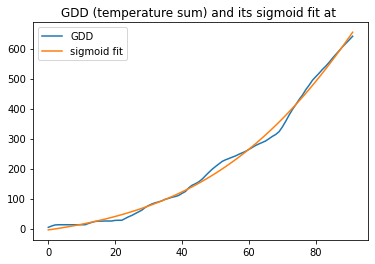

In [ ]:
def sigmoid (x, A, h, slope, C):
    return 1 / (1 + np.exp ((x - h) / slope)) *  A + C

# ищем параметры для уравнения
p, _ = curve_fit(sigmoid, np.array(range(len(df['GDD']))) , df['GDD'])

# рисуем графики
plt.plot(np.array(range(len(df['GDD']))) , df['GDD'], label='GDD')
plt.plot(np.array(range(len(df['GDD']))) , sigmoid(np.array(range(len(df['GDD']))), *p), label='sigmoid fit')
plt.legend()
plt.title('GDD (temperature sum) and its sigmoid fit at ');



In [ ]:
# само уравнение
print(f'Уравнение сигмоида: 1 / (1 + exp ((x - {p[1]}) / {p[2]}) * {p[0]} + {p[3]}')

Уравнение сигмоида: 1 / (1 + exp ((x - 113.98172284209446) / -30.18482510546742) * 2226.7793049707525 + -54.38833273170229


# The GDD jerk

**the third derivative** of the GDD fit, i.e. the GDD ‘jerk’ or the acceleration of temperature

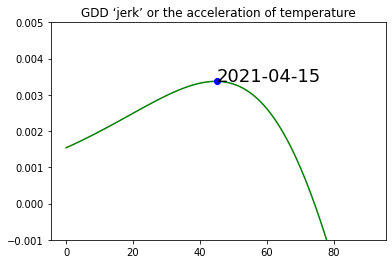

In [ ]:
# определяем функцию по вычисленным параметрам
def function(x):
    return 1 / (1 + np.exp ((x - p[1]) / p[2])) * p[0] + p[3]
  
# вычисляем третью производную n = 3
def deriv(x):
    return derivative(function, x, n=3, order=5)
  
# определяем ось х
y = np.array(range(len(df['GDD'])))

# находим пик
peaks, _ = find_peaks(deriv(y), height=0)
x = peaks[0]

# рисуем график
plt.plot(y, deriv(y), color='green', label='Derivative')
plt.plot(x, deriv(x), 'bo')
plt.text(x, deriv(x), df['datetime'][x], fontsize=18)
plt.plot()
plt.ylim([-0.001, 0.005])
plt.title('GDD ‘jerk’ or the acceleration of temperature');